# Slicing and dicing GRIB data

## Terminology

A GRIB file consists of a sequence of self-contained GRIB *messages*. A GRIB file is represented as a *Fieldset* object in Metview. Each message contains the data for a single *field*, e.g. a single parameter generated at a single time at a single level for a single forecast step. A field contains a set of *gridpoints* geographically distributed in some way, plus metadata such as the parameter, the generation time, the forecast step and the centre that generated the data. A field may be plotted on a map, and a Fieldset may be plotted as an animation on a map.

## Setting up

In [3]:
import numpy as np
import metview as mv

In [4]:
# not strictly necessary to tell Metview that we're running in a Jupyter notebook,
# but we will call this function so that we can specify a larger font size
mv.setoutput('jupyter', output_width=700, output_font_scale=1.5)

## Reading and inspecting the data

In [81]:
# get the data - if not already on disk then download
filename = "grib_to_be_sliced.grib"
if not mv.exist(filename):
    data = mv.gallery.load_dataset(filename)
else:
    data = mv.read('grib_to_be_sliced.grib')
print(data)

Fieldset (191 fields)


In [6]:
# get an overview of the data in the GRIB file
data.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
2t,surface,0,20220608,1200,"0,6,...",0,167,od,oper,fc,0001
lsm,surface,0,20220608,1200,0,0,172,od,oper,fc,0001
q,isobaricInhPa,"100,150,...",20220608,1200,0,0,133,od,oper,fc,0001
r,isobaricInhPa,"100,150,...",20220608,1200,0,0,157,od,oper,fc,0001
t,isobaricInhPa,"100,150,...",20220608,1200,"0,6,...",0,130,od,oper,fc,0001
trpp,tropopause,0,20220608,1200,0,None,228045,od,oper,fc,0001
z,isobaricInhPa,"100,150,...",20220608,1200,0,0,129,od,oper,fc,0001


In [85]:
# dive into a specific parameter
data.describe('r')

shortName,r
name,Relative humidity
paramId,157
units,%
typeOfLevel,isobaricInhPa
level,"100,150,200,250,300,400,500,700,850,925,1000"
date,20220608
time,1200
step,0
class,od
stream,oper


In [8]:
data.describe('z')

shortName,z
name,Geopotential
paramId,129
units,m**2 s**-2
typeOfLevel,isobaricInhPa
level,"100,150,200,250,300,400,500,700,850,925,1000"
date,20220608
time,1200
step,0
class,od
stream,oper


In [9]:
data.describe('t')

shortName,t
name,Temperature
paramId,130
units,K
typeOfLevel,isobaricInhPa
level,"100,150,200,250,300,400,500,700,850,925,1000"
date,20220608
time,1200
step,"0,6,12,18,24,30,36,42,48,54,60,66,72"
class,od
stream,oper


In [10]:
data.describe('lsm')

shortName,lsm
name,Land-sea mask
paramId,172
units,(0 - 1)
typeOfLevel,surface
level,0
date,20220608
time,1200
step,0
class,od
stream,oper


In [83]:
# similar to grib_ls on the command line - list all the fields
# - just print the first 20 - remove the [:20] to print all fields
data[:20].ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
Message,,,,,,,,,,
0,ecmf,2t,surface,0,20220608,1200,0,fc,0,reduced_gg
1,ecmf,2t,surface,0,20220608,1200,6,fc,0,reduced_gg
2,ecmf,2t,surface,0,20220608,1200,12,fc,0,reduced_gg
3,ecmf,2t,surface,0,20220608,1200,18,fc,0,reduced_gg
4,ecmf,2t,surface,0,20220608,1200,24,fc,0,reduced_gg
5,ecmf,2t,surface,0,20220608,1200,30,fc,0,reduced_gg
6,ecmf,2t,surface,0,20220608,1200,36,fc,0,reduced_gg
7,ecmf,2t,surface,0,20220608,1200,42,fc,0,reduced_gg
8,ecmf,2t,surface,0,20220608,1200,48,fc,0,reduced_gg


# Field selection

## Field selection through indexing

In [12]:
# select the first field (0-based indexing)
print(data[0])
data[0].ls()

Fieldset (1 field)


,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType
Message,,,,,,,,,
0,ecmf,2t,surface,0,20220608,1200,0,fc,reduced_gg


In [13]:
# select the fourth field (0-based indexing)
data[3].ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType
Message,,,,,,,,,
0,ecmf,2t,surface,0,20220608,1200,18,fc,reduced_gg


In [14]:
# select the last field
data[-1].ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType
Message,,,,,,,,,
0,ecmf,t,isobaricInhPa,100,20220608,1200,72,fc,reduced_gg


In [15]:
# index with numpy array
indices = np.array([1, 46, 27, 180])
data[indices].ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType
Message,,,,,,,,,
0,ecmf,2t,surface,0,20220608,1200,6,fc,reduced_gg
1,ecmf,r,isobaricInhPa,100,20220608,1200,0,fc,reduced_gg
2,ecmf,z,isobaricInhPa,500,20220608,1200,0,fc,reduced_gg
3,ecmf,t,isobaricInhPa,1000,20220608,1200,72,fc,reduced_gg


## Field selection through slicing

In [16]:
# select fields 4 to 7
data[4:8].ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType
Message,,,,,,,,,
0,ecmf,2t,surface,0,20220608,1200,24,fc,reduced_gg
1,ecmf,2t,surface,0,20220608,1200,30,fc,reduced_gg
2,ecmf,2t,surface,0,20220608,1200,36,fc,reduced_gg
3,ecmf,2t,surface,0,20220608,1200,42,fc,reduced_gg


In [17]:
# select fields 4 to 7, step 2
data[4:8:2].ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType
Message,,,,,,,,,
0,ecmf,2t,surface,0,20220608,1200,24,fc,reduced_gg
1,ecmf,2t,surface,0,20220608,1200,36,fc,reduced_gg


In [18]:
# select the last 5 fields
data[-5:].ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType
Message,,,,,,,,,
0,ecmf,t,isobaricInhPa,300,20220608,1200,72,fc,reduced_gg
1,ecmf,t,isobaricInhPa,250,20220608,1200,72,fc,reduced_gg
2,ecmf,t,isobaricInhPa,200,20220608,1200,72,fc,reduced_gg
3,ecmf,t,isobaricInhPa,150,20220608,1200,72,fc,reduced_gg
4,ecmf,t,isobaricInhPa,100,20220608,1200,72,fc,reduced_gg


In [84]:
# reverse the fields' order
reversed = data[::-1]
reversed[:20].ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType
Message,,,,,,,,,
0,ecmf,t,isobaricInhPa,100,20220608,1200,72,fc,reduced_gg
1,ecmf,t,isobaricInhPa,150,20220608,1200,72,fc,reduced_gg
2,ecmf,t,isobaricInhPa,200,20220608,1200,72,fc,reduced_gg
3,ecmf,t,isobaricInhPa,250,20220608,1200,72,fc,reduced_gg
4,ecmf,t,isobaricInhPa,300,20220608,1200,72,fc,reduced_gg
5,ecmf,t,isobaricInhPa,400,20220608,1200,72,fc,reduced_gg
6,ecmf,t,isobaricInhPa,500,20220608,1200,72,fc,reduced_gg
7,ecmf,t,isobaricInhPa,700,20220608,1200,72,fc,reduced_gg
8,ecmf,t,isobaricInhPa,850,20220608,1200,72,fc,reduced_gg


In [20]:
# assign this to a variable and write to disk
rev = data[::-1]
rev.write('reversed.grib')
print(rev)

Fieldset (191 fields)


## Field selection through metadata

In [21]:
# select() method, various ways
data.select(shortName='r').ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType
Message,,,,,,,,,
0,ecmf,r,isobaricInhPa,1000,20220608,1200,0,fc,reduced_gg
1,ecmf,r,isobaricInhPa,925,20220608,1200,0,fc,reduced_gg
2,ecmf,r,isobaricInhPa,850,20220608,1200,0,fc,reduced_gg
3,ecmf,r,isobaricInhPa,700,20220608,1200,0,fc,reduced_gg
4,ecmf,r,isobaricInhPa,500,20220608,1200,0,fc,reduced_gg
5,ecmf,r,isobaricInhPa,400,20220608,1200,0,fc,reduced_gg
6,ecmf,r,isobaricInhPa,300,20220608,1200,0,fc,reduced_gg
7,ecmf,r,isobaricInhPa,250,20220608,1200,0,fc,reduced_gg
8,ecmf,r,isobaricInhPa,200,20220608,1200,0,fc,reduced_gg


In [22]:
data.select(shortName='r', level=[500, 850]).ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType
Message,,,,,,,,,
0,ecmf,r,isobaricInhPa,850,20220608,1200,0,fc,reduced_gg
1,ecmf,r,isobaricInhPa,500,20220608,1200,0,fc,reduced_gg


In [23]:
# put the selection criteria into a dict, then modify it before using
# useful for programatically creating selection criteria
criteria = {"shortName": "z", "level": [500, 850]}
criteria["level"] = 300
data.select(criteria).ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType
Message,,,,,,,,,
0,ecmf,z,isobaricInhPa,300,20220608,1200,0,fc,reduced_gg


In [24]:
# shorthand way of expressing parameters and levels
data['r500'].ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType
Message,,,,,,,,,
0,ecmf,r,isobaricInhPa,500,20220608,1200,0,fc,reduced_gg


In [25]:
# specify units - useful if different level types in the same fieldset
data['r300hPa'].ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType
Message,,,,,,,,,
0,ecmf,r,isobaricInhPa,300,20220608,1200,0,fc,reduced_gg


## Combining fields

In [26]:
# generate 4 fieldsets - one will be from another GRIB file to show that we can
# combine fields from any number of different files

a = data[5]
b = data[78:80]
c = data['z']
d = mv.read('reversed.grib')[0]
print(a, b, c, d)

Fieldset (1 field) Fieldset (2 fields) Fieldset (11 fields) Fieldset (1 field)


In [27]:
# create a new Fieldset out of existing ones
combined = mv.merge(a, b, c, d)
combined.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType
Message,,,,,,,,,
0,ecmf,2t,surface,0,20220608,1200,30,fc,reduced_gg
1,ecmf,t,isobaricInhPa,200,20220608,1200,12,fc,reduced_gg
2,ecmf,t,isobaricInhPa,150,20220608,1200,12,fc,reduced_gg
3,ecmf,z,isobaricInhPa,1000,20220608,1200,0,fc,reduced_gg
4,ecmf,z,isobaricInhPa,925,20220608,1200,0,fc,reduced_gg
5,ecmf,z,isobaricInhPa,850,20220608,1200,0,fc,reduced_gg
6,ecmf,z,isobaricInhPa,700,20220608,1200,0,fc,reduced_gg
7,ecmf,z,isobaricInhPa,500,20220608,1200,0,fc,reduced_gg
8,ecmf,z,isobaricInhPa,400,20220608,1200,0,fc,reduced_gg


In [28]:
# use the Fieldset constructor to do the same thing from a
# list of Fieldsets
combined = mv.Fieldset(fields=[a, b, c, d])
combined.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType
Message,,,,,,,,,
0,ecmf,2t,surface,0,20220608,1200,30,fc,reduced_gg
1,ecmf,t,isobaricInhPa,200,20220608,1200,12,fc,reduced_gg
2,ecmf,t,isobaricInhPa,150,20220608,1200,12,fc,reduced_gg
3,ecmf,z,isobaricInhPa,1000,20220608,1200,0,fc,reduced_gg
4,ecmf,z,isobaricInhPa,925,20220608,1200,0,fc,reduced_gg
5,ecmf,z,isobaricInhPa,850,20220608,1200,0,fc,reduced_gg
6,ecmf,z,isobaricInhPa,700,20220608,1200,0,fc,reduced_gg
7,ecmf,z,isobaricInhPa,500,20220608,1200,0,fc,reduced_gg
8,ecmf,z,isobaricInhPa,400,20220608,1200,0,fc,reduced_gg


In [29]:
# append to an existing Fieldset - unlike the other functions,
# this modifies the input Fieldset
# let's use it in a loop to construct a new Fieldset

new = mv.Fieldset() # create an empty Fieldset
for x in [a,b,c,d]:
    print('appending', x)
    new.append(x)
    print(new)

appending Fieldset (1 field)
Fieldset (1 field)
appending Fieldset (2 fields)
Fieldset (3 fields)
appending Fieldset (11 fields)
Fieldset (14 fields)
appending Fieldset (1 field)
Fieldset (15 fields)


# Point selection

## Area cropping

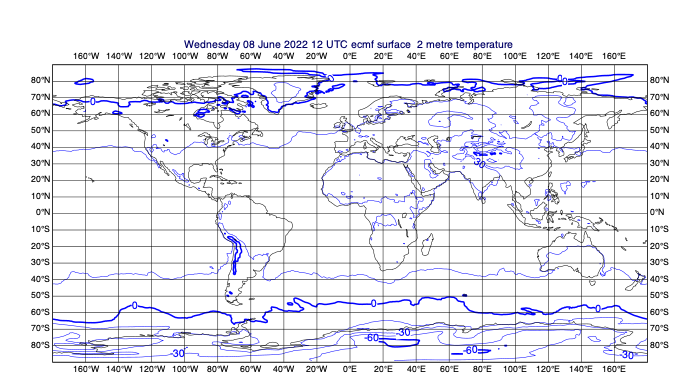

In [30]:
# first select 2m temperature and plot it to see what we've got
few_fields = data.select(shortName='2t')
mv.plot(few_fields)

In [31]:
# select an area [N,W,S,E]
data_area = [70, -25, 28, 45]
data_on_subarea = mv.read(data=few_fields, area=data_area)

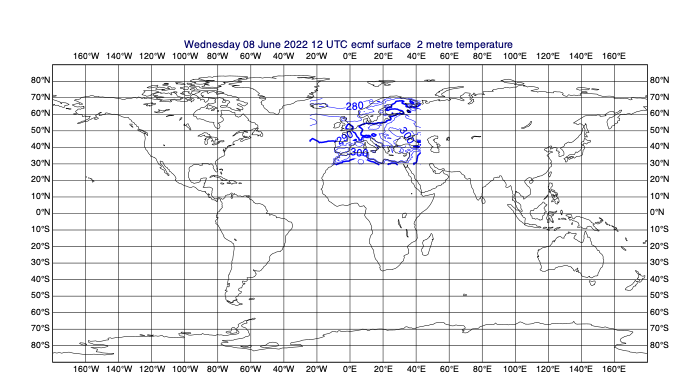

In [32]:
# plot the fields to see
mv.plot(data_on_subarea)

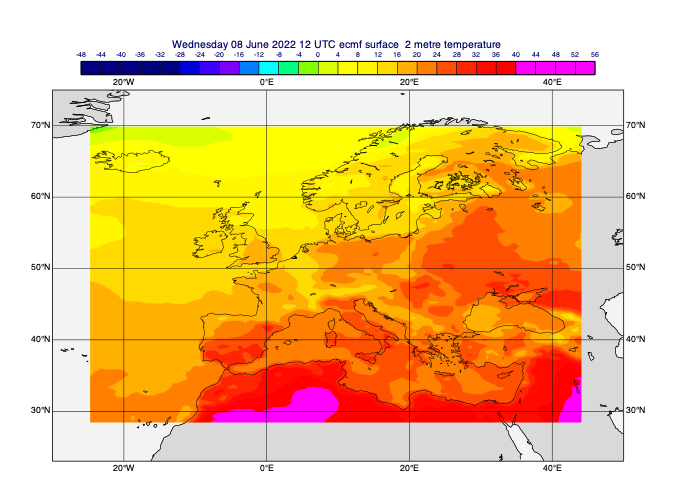

In [33]:
# add some automatic styling and zoom into the area
margins = [5, -5, -5, 5]
view_area = [a + b for a, b in zip(data_area, margins)]
coastlines = mv.mcoast(map_coastline_land_shade=True,
                       map_coastline_land_shade_colour="RGB(0.85,0.85,0.85)",
                       map_coastline_sea_shade=True,
                       map_coastline_sea_shade_colour="RGB(0.95,0.95,0.95)",)
view = mv.geoview(map_area_definition="corners", area=view_area, coastlines=coastlines)
cont_auto = mv.mcont(legend=True, contour_automatic_setting="ecmwf", grib_scaling_of_derived_fields=True)
mv.plot(view, data_on_subarea, cont_auto)

## Point reduction with regridding

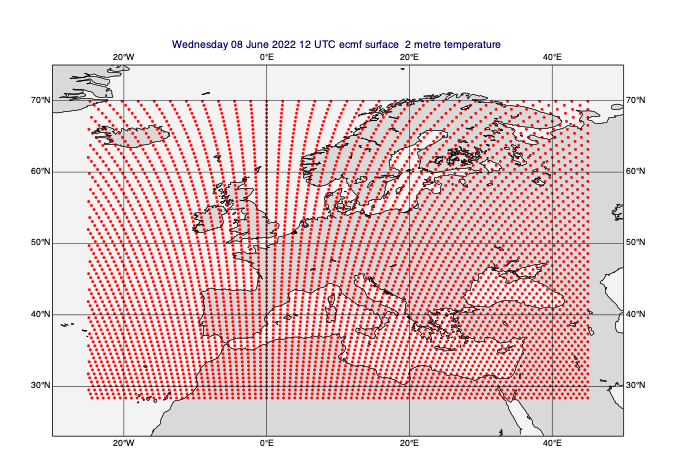

In [34]:
# let's plot the data points to see what the grid looks like
gridpoint_markers = mv.mcont(
    contour                          = "off",
    contour_grid_value_plot          = "on",
    contour_grid_value_plot_type     = "marker",
    contour_grid_value_marker_height = 0.2,
    contour_grid_value_marker_index  = 15,
    )
mv.plot(view, data_on_subarea[0], gridpoint_markers)

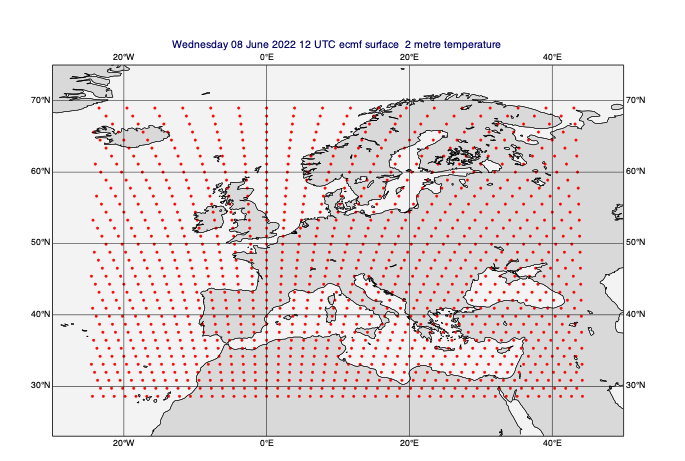

In [35]:
# regrid to a lower-resolution octahedral reduced Gaussian grid
lowres_data = mv.read(data=data_on_subarea, grid="O80")
mv.plot(view, lowres_data[0], gridpoint_markers)

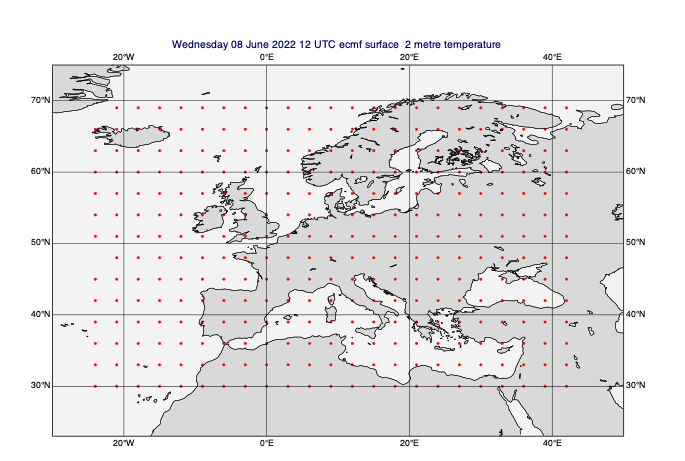

In [36]:
# regrid to a regular lat/lon grid
lowres_data = mv.read(data=data_on_subarea, grid=[3, 3]) # 3 degrees
mv.plot(view, lowres_data[0], gridpoint_markers)

## Masking

In [37]:
# masking in Metview means defining an area and either:
#   creating a field with 1s inside the area and 0s outside (missing=False)
#   or
#   turning the values outside the area into missing values (missing=True)

In [38]:
# we will use temperature data at step 0 to be masked
t0 = data.select(shortName='2t', step=0)

### Geographic masking
This is where we define regions of a field to be preserved, while the points outside those regions are filled with missing values.

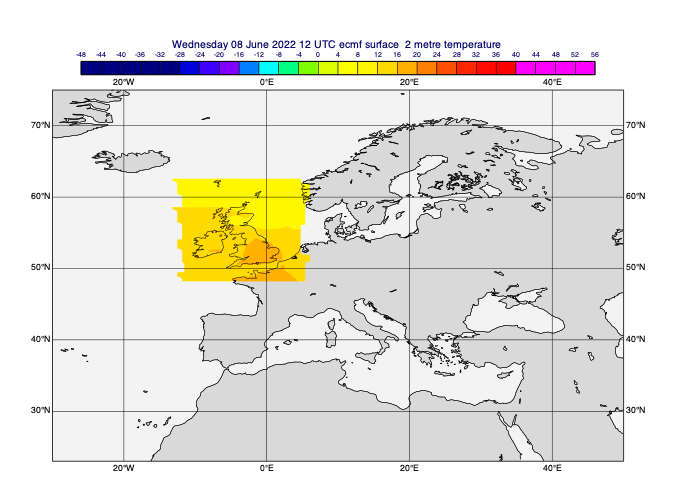

In [39]:
# define a rectangular mask
rect_masked_data = mv.mask(t0, [48, -12, 63, 5], missing=True) # [N,W,S,E]
mv.plot(view, rect_masked_data, cont_auto)

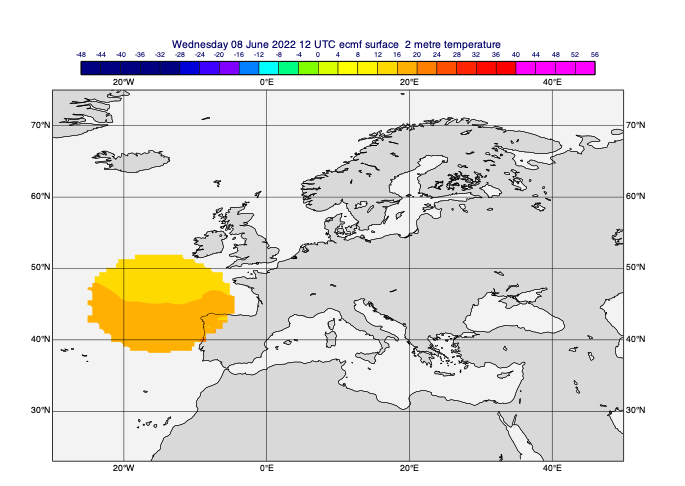

In [40]:
# define a circular mask - centre in lat/lon, radius in m
circ_masked_data = mv.rmask(t0, [45, -15, 800*1000], missing=True) # [N,W,S,E]
mv.plot(view, circ_masked_data, cont_auto)

In [41]:
# polygon area - we will use a shapefile from Magics
import shapefile # pip install pyshp

# download a shapefile with geographic shapes
filename = "ne_50m_land.zip"
if not mv.exist(filename):
    mv.gallery.load_dataset(filename)

sf = shapefile.Reader("ne_50m_land.shp")

In [42]:
# extract the list of points for the Great Britain polygon
shapes = sf.shapes()
points = shapes[135].points  # GB
lats = np.array([p[1] for p in points])
lons = np.array([p[0] for p in points])

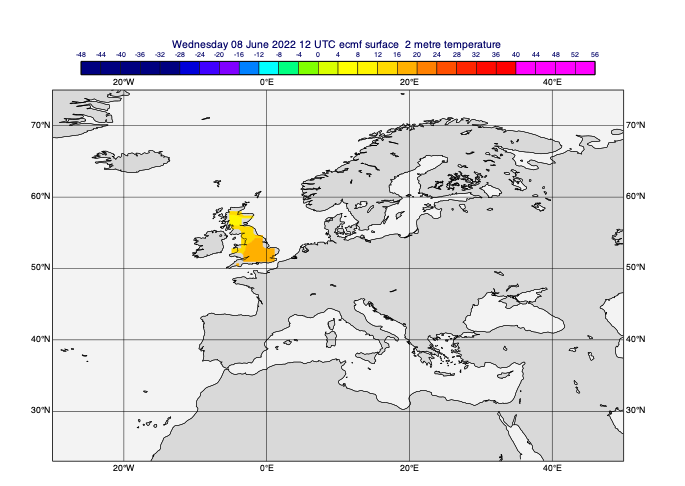

In [43]:
poly_masked_data = mv.poly_mask(t0, lats, lons, missing=True)
mv.plot(view, poly_masked_data, cont_auto)

### Frames
Frames are useful to supply boundary conditions to a local area model.


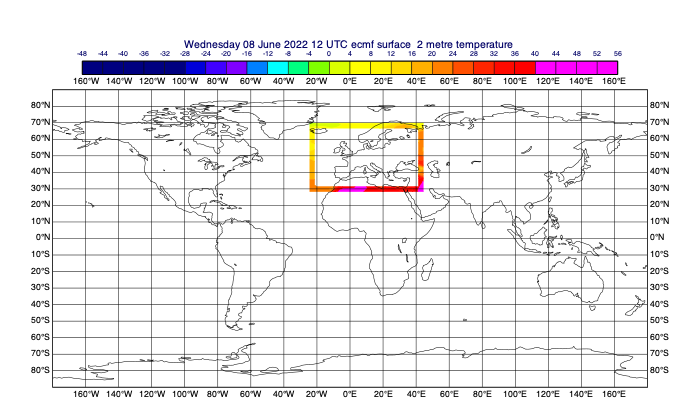

In [44]:
# the frame parameter is the width of the frame in number of grid points
data_frame = mv.read(data=t0, area=data_area, frame=5, grid=[1,1])
mv.plot(data_frame, cont_auto)

In [45]:
print('mean value for original data    :', t0.average())
print('mean value for rect masked data :', rect_masked_data.average())
print('mean value for circ masked data :', circ_masked_data.average())
print('mean value for poly masked data :', poly_masked_data.average())
print('mean value for framed data      :', data_frame.average())

mean value for original data    : 290.50474329841205
mean value for rect masked data : 286.387063778148
mean value for circ masked data : 289.58698738395395
mean value for poly masked data : 288.6206938091077
mean value for framed data      : 293.29336794339696


### Computational masking
This is where we generate masks consisting of 1s where the points are inside a given region (or satisfy some other criteria) and 0s otherwise. We can then combine these and use them to provide a missing value mask to any field.

In [46]:
# contouring for 0 and 1 values
mask_1_and_0_contouring = mv.mcont(
    legend="on",
    contour="off",
    contour_level_selection_type="level_list",
    contour_level_list=[0, 1, 2],
    contour_shade="on",
    contour_shade_technique="grid_shading",
    contour_shade_max_level_colour="red",
    contour_shade_min_level_colour="yellow",
)

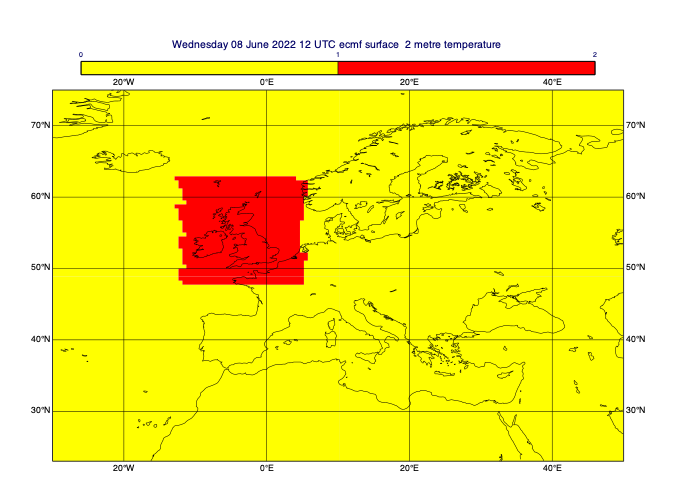

In [47]:
# define a rectangular mask
rect_masked_data = mv.mask(t0, [48, -12, 63, 5], missing=False) # [N,W,S,E]
mv.plot(view, rect_masked_data, mask_1_and_0_contouring)

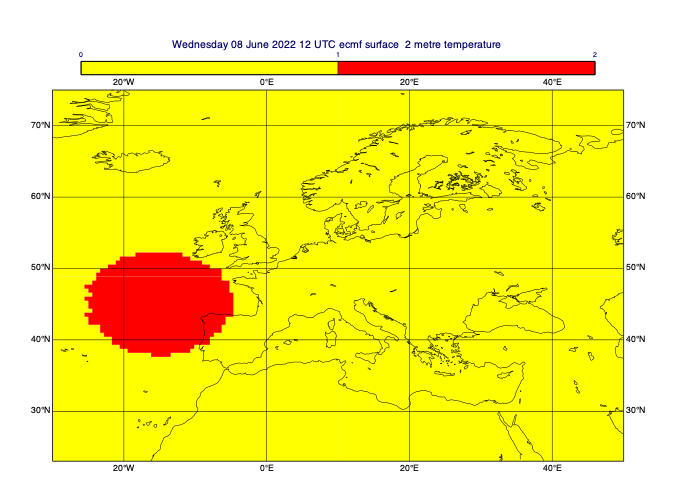

In [48]:
# define a circular mask - centre in lat/lon, radius in m
circ_masked_data = mv.rmask(t0, [45, -15, 800*1000], missing=False) # [N,W,S,E]
mv.plot(view, circ_masked_data, mask_1_and_0_contouring)

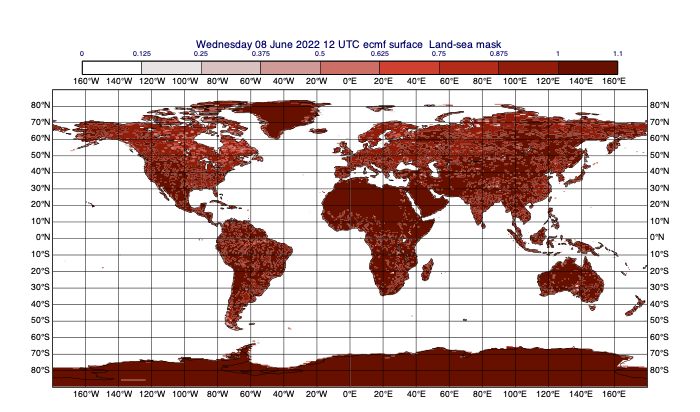

In [49]:
# we will now define a mask based on the land-sea mask field; let's plot it first
lsm = data.select(shortName='lsm')
lsm_contour = mv.mcont(
    legend=True,
    contour=False,
    contour_label=False,
    contour_max_level=1.1,
    contour_shade='on',
    contour_shade_technique='grid_shading',
    contour_shade_method='area_fill',
    contour_shade_min_level_colour='white',
    contour_shade_max_level_colour='brown',
)
mv.plot(lsm, lsm_contour)

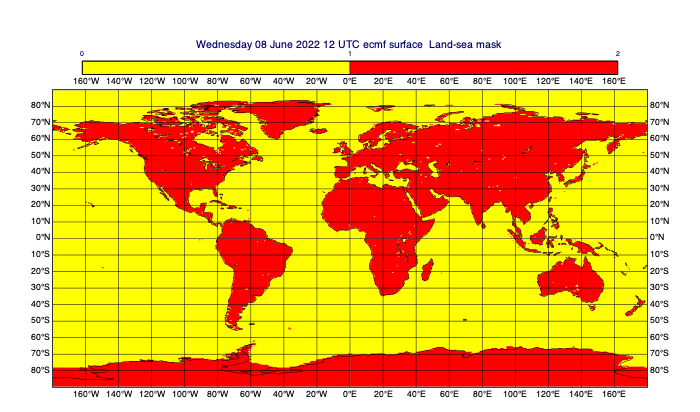

In [50]:
# for the purposes of our mask, consider lsm>0.5 to be land
land = lsm > 0.5
mv.plot(land, mask_1_and_0_contouring)

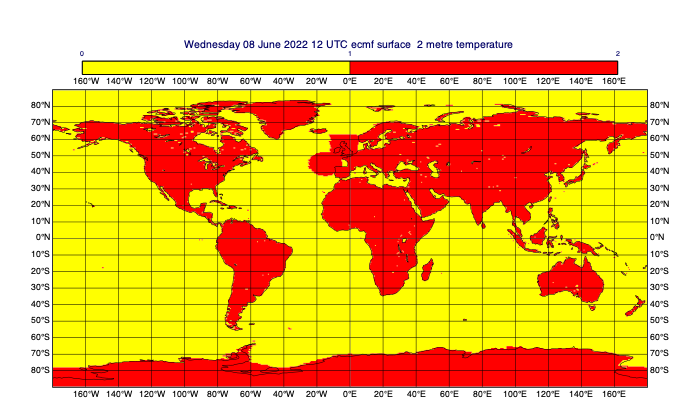

In [51]:
# combine the masks with the 'or' operator (only useful for 1/0 masks)
# use '&' to compute the intersection of masks
combined_mask_data = rect_masked_data | circ_masked_data | land
mv.plot(combined_mask_data, mask_1_and_0_contouring)

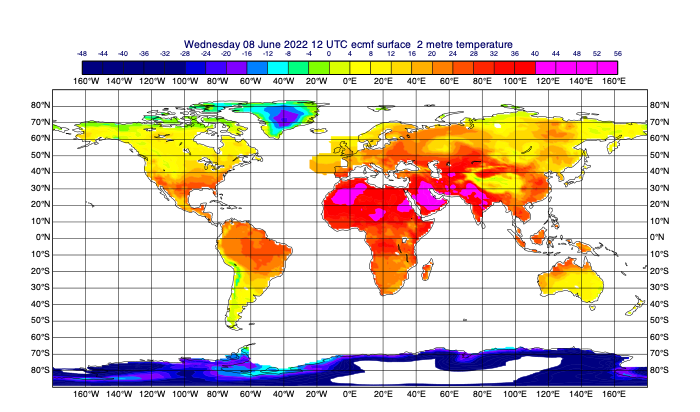

In [52]:
# use this mask to replace 0s with missing values in the original data
combined_mask_data = mv.bitmap(combined_mask_data, 0) # replace 0 with missing vals
masked_data = mv.bitmap(t0, combined_mask_data) # copy missing vals over
mv.plot(masked_data, cont_auto)

## Vertical profiles
Vertical profiles can be extracted from GRIB data for a given point or area (with spatial averaging) for each timestep separately.

In [53]:
t0 = data.select(shortName='t', step=0)
t0.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType
Message,,,,,,,,,
0,ecmf,t,isobaricInhPa,1000,20220608,1200,0,fc,reduced_gg
1,ecmf,t,isobaricInhPa,925,20220608,1200,0,fc,reduced_gg
2,ecmf,t,isobaricInhPa,850,20220608,1200,0,fc,reduced_gg
3,ecmf,t,isobaricInhPa,700,20220608,1200,0,fc,reduced_gg
4,ecmf,t,isobaricInhPa,500,20220608,1200,0,fc,reduced_gg
5,ecmf,t,isobaricInhPa,400,20220608,1200,0,fc,reduced_gg
6,ecmf,t,isobaricInhPa,300,20220608,1200,0,fc,reduced_gg
7,ecmf,t,isobaricInhPa,250,20220608,1200,0,fc,reduced_gg
8,ecmf,t,isobaricInhPa,200,20220608,1200,0,fc,reduced_gg


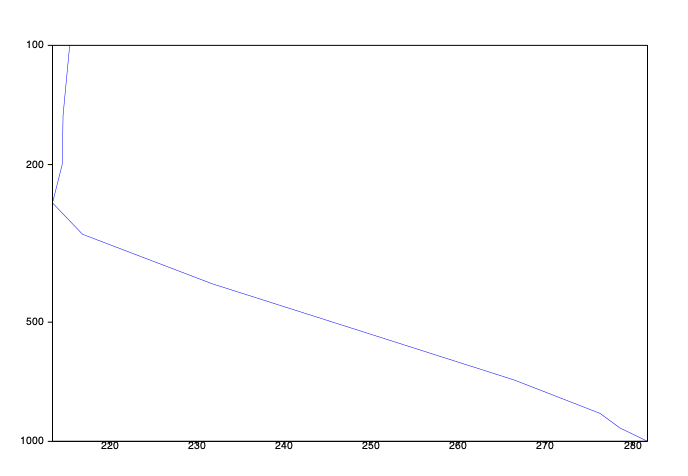

In [54]:
# the vertical profile view extracts the data for every level and generates a plot
vpview = mv.mvertprofview(
    input_mode="point",
    point=[-50, -70], # lat,lon
    bottom_level=1000,
    top_level=100,
    vertical_scaling="log",)
mv.plot(vpview, t0)

In [55]:
# let's plot a profile for each forecast step of temperature

# we will extract one Fieldset for each time step - each of these Fieldsets
# will contain all the vertical levels of temperature data for that time step
# we will end up with a list of these Fieldsets and plot a profile for each

steps = mv.unique(mv.grib_get_long(data, 'step'))
data_for_all_steps = [data.select(shortName='t', step=s) for s in steps]
for f in data_for_all_steps:
    print(f.grib_get_long('step')[0], f.grib_get_long('level'))

0.0 [1000.0, 925.0, 850.0, 700.0, 500.0, 400.0, 300.0, 250.0, 200.0, 150.0, 100.0]
6.0 [1000.0, 925.0, 850.0, 700.0, 500.0, 400.0, 300.0, 250.0, 200.0, 150.0, 100.0]
12.0 [1000.0, 925.0, 850.0, 700.0, 500.0, 400.0, 300.0, 250.0, 200.0, 150.0, 100.0]
18.0 [1000.0, 925.0, 850.0, 700.0, 500.0, 400.0, 300.0, 250.0, 200.0, 150.0, 100.0]
24.0 [1000.0, 925.0, 850.0, 700.0, 500.0, 400.0, 300.0, 250.0, 200.0, 150.0, 100.0]
30.0 [1000.0, 925.0, 850.0, 700.0, 500.0, 400.0, 300.0, 250.0, 200.0, 150.0, 100.0]
36.0 [1000.0, 925.0, 850.0, 700.0, 500.0, 400.0, 300.0, 250.0, 200.0, 150.0, 100.0]
42.0 [1000.0, 925.0, 850.0, 700.0, 500.0, 400.0, 300.0, 250.0, 200.0, 150.0, 100.0]
48.0 [1000.0, 925.0, 850.0, 700.0, 500.0, 400.0, 300.0, 250.0, 200.0, 150.0, 100.0]
54.0 [1000.0, 925.0, 850.0, 700.0, 500.0, 400.0, 300.0, 250.0, 200.0, 150.0, 100.0]
60.0 [1000.0, 925.0, 850.0, 700.0, 500.0, 400.0, 300.0, 250.0, 200.0, 150.0, 100.0]
66.0 [1000.0, 925.0, 850.0, 700.0, 500.0, 400.0, 300.0, 250.0, 200.0, 150.0, 1

In [56]:
# we will plot the profile for each step in a different colour - generate a list
# of 'mgraph' definitions, each using a different colour, for this purpose
nsteps = len(steps)
colour_inc = 1/nsteps
graph_colours = [mv.mgraph(legend=True,
                           graph_line_thickness=2,
                           graph_line_colour='HSL('+str(360*s*colour_inc)+',1,0.45)') for s in range(len(steps))]

# define a nice legend
legend = mv.mlegend(
    legend_display_type="disjoint",
    legend_entry_plot_direction="column",
    legend_text_composition="user_text_only",
    legend_entry_plot_orientation="top_bottom",
    legend_border_colour="black",
    legend_box_mode="positional",
    legend_box_x_position=2.5,
    legend_box_y_position=4,
    legend_box_x_length=5,
    legend_box_y_length=8,
    legend_text_font_size=0.4,
    legend_user_lines=[str(int(s)) for s in steps],
)

# define the axis labels
vertical_axis = mv.maxis(
    axis_type="position_list",
    axis_tick_position_list=data_for_all_steps[0].grib_get_long('level')
)


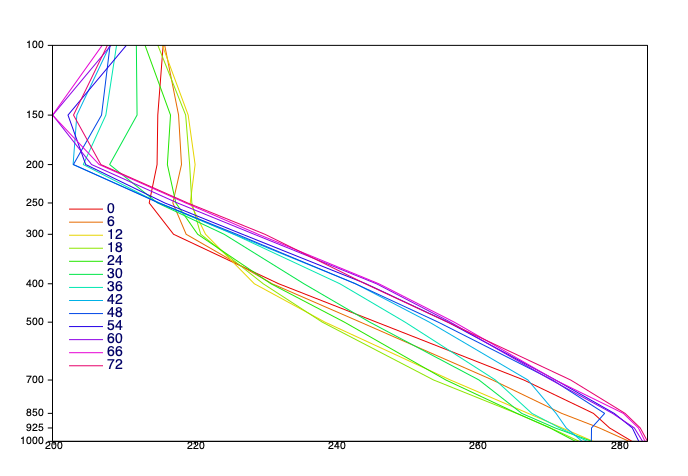

In [57]:
# finally, the magic happens here - the vertical profile view extracts the data
# at the given point at each level
vpview = mv.mvertprofview(
    input_mode="point",
    point=[-50, -70], # lat,lon
    bottom_level=1000,
    top_level=100,
    vertical_scaling="log",
    level_axis=vertical_axis
)
mv.plot(vpview, list(zip(data_for_all_steps, graph_colours)), legend)

## Thermodynamic profiles

A special version of the point profile extraction is implemented by [mthermo_grib()](../gen_files/icon_functions/mthermo_grib.rst), which generates input data for thermodynamic diagrams (e.g. tephigrams). Metview is 
able to use these profiles to compute thermodynamic parcel paths and stability parameters like CAPE and CIN.

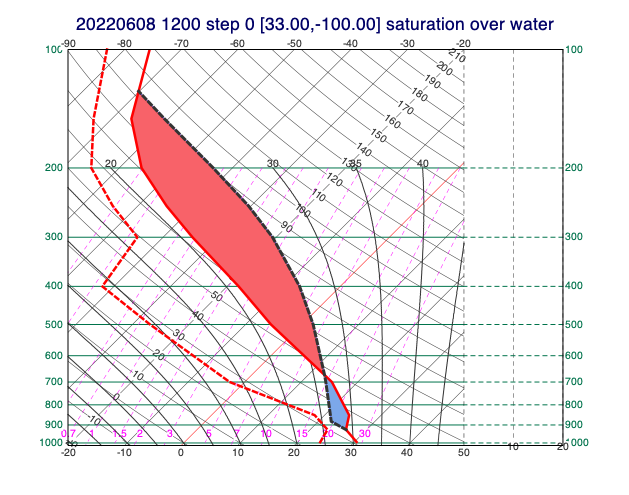

In [58]:
# extract temperature and specific humidity for all the levels 
# for a given timestep
tq_data = data.select(shortName=["t", "q"], step=0)

# extract thermo profile
location = [33, -100]  # lat, lon
prof = mv.thermo_grib(coordinates=location, data=tq_data)

# compute parcel path - maximum cape up to 700 hPa from the surface
parcel = mv.thermo_parcel_path(prof, {"mode": "most_unstable", "top_p": 700})

# create plot object for parcel areas and path
parcel_area = mv.thermo_parcel_area(parcel)
parcel_vis = mv.xy_curve(parcel["t"], parcel["p"], "charcoal", "dash", 6)

# define temperature and dewpoint profile style
prof_vis = mv.mthermo(
    thermo_temperature_line_thickness=5, thermo_dewpoint_line_thickness=5
)

# define a skew-T thermodynamic diagram view
view = mv.thermoview(type="skewt")

# plot the profile, parcel areas and parcel path together
mv.plot(view, parcel_area, prof, prof_vis, parcel_vis)

## Vertical cross sections

For a **vertical cross section** data is extracted along a transect line for all the vertical levels for a given timestep. We can choose wether we want to generate the cross section by **interpolating** the values onto the transect line or use the **nearest gridpoint** method.

### Using the cross section view

The simplest way to generate a cross section is to use the cross section view ([mxsectview()](../gen_files/icon_functions/mxsectview.rst)), which will automatically preform the data extraction on the input GRIB fields.

In [59]:
# define the cross section line
line=[66, -44, 38,-30] # lat1,lon1,lat2,lon2

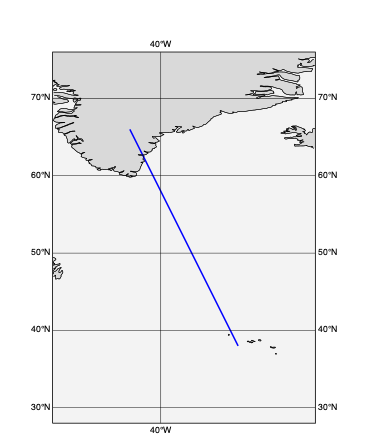

In [87]:
def plot_geo_line(line):
    margins = [10, -10, -10, 10]
    view_area = [a + b for a, b in zip(line, margins)]
    view = mv.geoview(map_area_definition="corners", area=view_area, coastlines=coastlines)
    geoline = mv.mvl_geoline(*line, 0.1)
    mgr = mv.mgraph(graph_line_thickness=3)
    return mv.plot(view, geoline, mgr)

plot_geo_line(line)

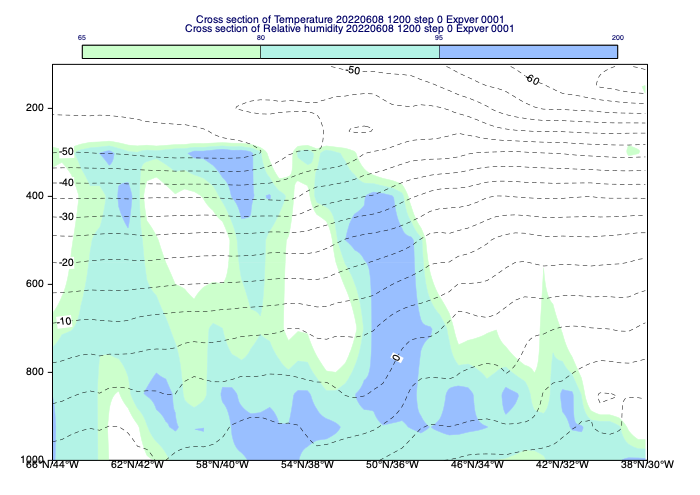

In [61]:
# define the cross section view
cs_view = mv.mxsectview(
    bottom_level=1000,
    top_level=100,
    line=line,
    horizontal_point_mode="interpolate",
)

# extract temperature and relative humidity for the first timestep
# for all the levels. We scale temperature values from to Celsius units
# for plotting
t = data.select(shortName="t", step=0) - 273.16
r = data.select(shortName="r", step=0)

# define the contouring styles for the cross section
cont_xs_t = mv.mcont(
    contour_line_style           = "dash",
    contour_line_colour          = "black",
    contour_highlight            = "off",
    contour_level_selection_type = "interval",
    contour_interval             = 5
    )

cont_xs_r = mv.mcont(
    contour_automatic_setting = "style_name",
    contour_style_name        = "sh_grnblu_f65t100i15_light",
    legend                    = "on"
    )

# generate the cross section plot. The computations are automatically performed according
# to the settings in the view.
mv.plot(cs_view, r, cont_xs_r, t, cont_xs_t)

### Accessing the cross section data

The actual results of the cross section computations are stored in a custom NetCDF format. If we want to access it [mcross_sect()](../gen_files/icon_functions/mcross_sect.rst) should be used instead of the view.

In [62]:
# compute cross section data for temperature
xs_t = mv.mcross_sect( 
    data=t, 
    bottom_level=1000,
    top_level=100,
    line=line,
    horizontal_point_mode="interpolate")

# write netCDF  data to disk
mv.write("xs_t.nc", xs_t)

# dump the data contents
import xarray as xr
ds_t= xr.open_dataset("xs_t.nc")
ds_t

<xarray.Dataset>
Dimensions:  (time: 1, lat: 64, lon: 64, nlev: 11)
Coordinates:
  * time     (time) datetime64[ns] 2022-06-08T12:00:00
  * lat      (lat) float64 66.0 65.56 65.11 64.67 ... 39.33 38.89 38.44 38.0
  * lon      (lon) float64 -44.0 -43.78 -43.56 -43.33 ... -30.44 -30.22 -30.0
Dimensions without coordinates: nlev
Data variables:
    t_lev    (time, nlev) float64 ...
    t        (time, nlev, lon) float64 ...
Attributes:
    _FillValue:          1e+22
    _View:               MXSECTIONVIEW
    type:                MXSECTION
    xsHorizontalMethod:  interpolate
    title:               Cross section of Temperature 20220608 1200 step 0 Ex...

### Plotting the cross section data and using it for single level slicing

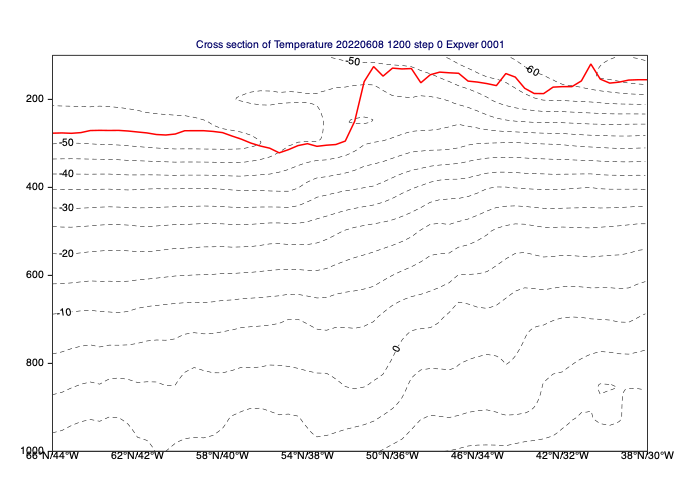

In [63]:
# read tropopause pressure (it is a single level field)
trpp = data.select(shortName="trpp", step=0)

# using the temperature cross section object we can extract a slice from trpp along the
# transect line and build a curve object out of it. The pressure has to be scaled
# from Pa to hPa.
trpp_curve = mv.xs_build_curve(xs_t, trpp/100, "red", "solid", 3)

# directly plot the temperature cross section data and the trpp curve
mv.plot(xs_t, cont_xs_t,  trpp_curve)

## Average vertical cross sections

This is a variant of the vertical cross section where either a **zonal** or **meridional** average is computed for all the levels in a given timestep. Similarly to the cross section the input data can be directly plotted into a view ([maverageview()](../gen_files/icon_functions/maverageview.rst)) or passed on to [mxs_average()](../gen_files/icon_functions/mxs_average.rst) to generate average cross section NetCDF data.

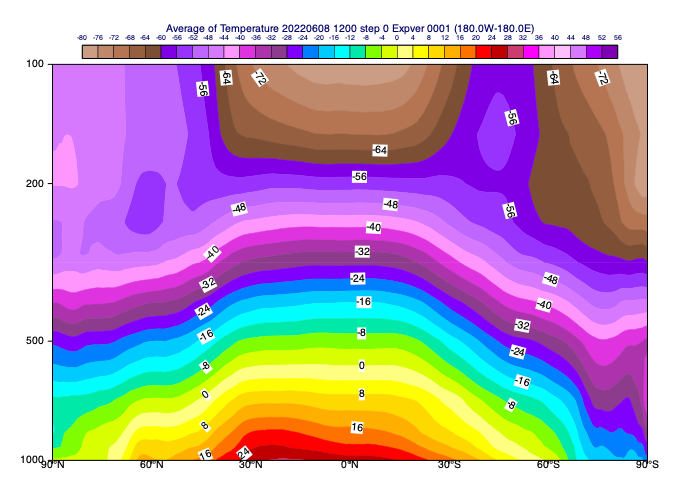

In [64]:
# set up the average view for a global zonal mean
av_view = mv.maverageview(
    top_level=100,
    bottom_level=1000,
    vertical_scaling="log",
    area=[90,-180, -90, 180], # N, W, S, E
    direction="ew"
)

# extract temperature for the first timestep for all the levels. We scale
# temperature values to Celsius units for plotting
t = data.select(shortName="t", step=0)
t = t - 273.16

# define the contouring styles for the zonal mean cross section
cont_zonal_t = mv.mcont(
    contour_automatic_setting = "style_name",
    contour_style_name        = "sh_all_fM80t56i4_v2",
    legend                    = "on"
    )
    
# generate the average cross section plot. The computations are automatically 
# performed according to the settings in the view.
mv.plot(av_view, t, cont_zonal_t)

## Hovmoeller diagrams

**Hovmoeller** diagrams are special sections for (mostly single level) fields where one axis is always the time while the other one can be derived in various ways. Metview supports 3 flavours of it: 
- area Hovmoellers
- vertical Hovmoellers 
- line Hovmoellers

### Area Hovmoeller diagrams

In this diagram type for each date and time either **zonal or meridional averaging** is performed on the data. The example below shows a Hovmoeller diagram with longitude on the horizontal axis and time on the vertical axis. Each point in the plot is a meridional average performed for temerature on 500 hPa at the given time in North-South (meridional) direction.

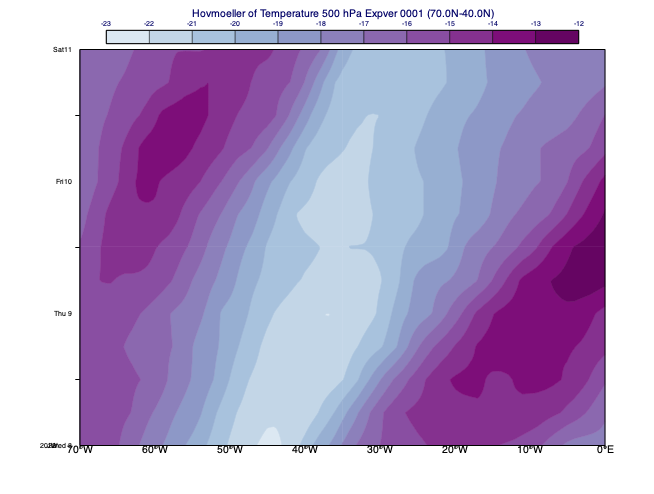

In [65]:
# define the Hovmoeller view for an area in the North-Atlantic and
# choose meridional averaging
view = mv.mhovmoellerview(
    type="area_hovm",
    area=[70, -70, 40, 0],
    average_direction="north_south",
)

# extract temperature on 500 hPa for all the timestep and 
# convert it into Celsius units for plotting
t = data.select(shortName="t", level=500)
t = t - 273.16

# define contour shading
cont_hov_t = mv.mcont(
    legend                       = "on",
    contour                      = "off",
    contour_level_selection_type = "interval",
    contour_max_level            = -12,
    contour_min_level            = -23,
    contour_interval             = 1,
    contour_label                = "off",
    contour_shade                = "on",
    contour_shade_colour_method  = "palette",
    contour_shade_method         = "area_fill",
    contour_shade_palette_name   = "m_purple2_11"
    )

# generate the area Hovmoeller plot. The computations are automatically 
# performed according to the settings in the view.
mv.plot(view, t, cont_hov_t)


### Vertical Hovmoeller diagrams

In this diagram type the horizontal axis is time and the vertical axis is a vertical co-ordinate. The data is extracted for a given location or generated by spatial averaging over an area. The example below shows the temperature forecast evolution for a selected point having pressure as the vertical axis.

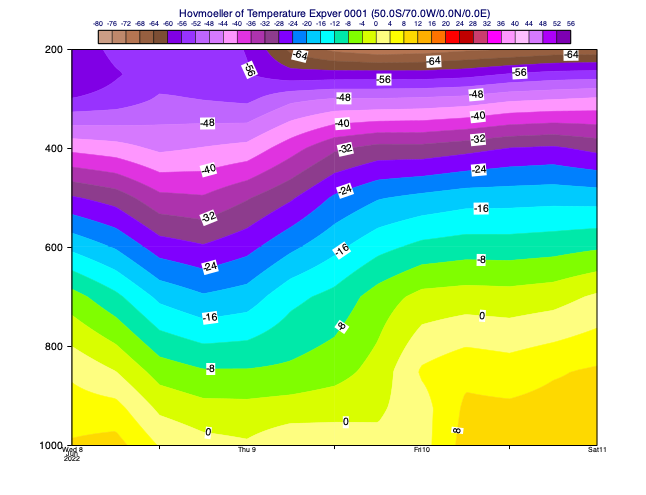

In [66]:
# define a vertical Hovmoeller view for a location. The point data 
# is extracted with the nearest gridpoint method 
view = mv.mhovmoellerview(
    type="vertical_hovm",
    bottom_level=1000,
    top_level=200,
    input_mode="nearest_gridpoint",
    point=[-50, -70],
)

# extract the temperature on all the levels and timesteps. Values 
# scaled to Celsius units for plotting
t = data.select(shortName="t")
t = t - 273.16

# generate the vertical Hovmoeller plot. The computations are automatically 
# performed according to the settings in the view.
mv.plot(view, t, cont_zonal_t)

### Line Hovmoeller diagrams

In this diagram type the data is extracted along a transect line from a single level field for multiple dates and times. In the resulting plot one axis is time while the other goes along the transect line. The example below shows a line Hovmoeller diagram for the 2m temperature forecast evolution along a line across Lake Victoria.

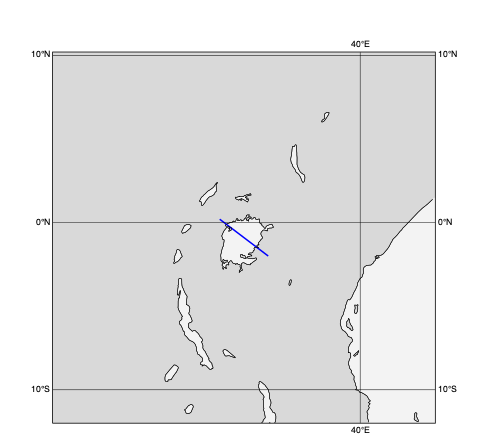

In [88]:
# define a line Hovmoeller view for a transect line across Lake Victoria
line_across_lake_victoria = [0.2, 31.6, -2, 34.5]  # N,W,S,E
plot_geo_line(line_across_lake_victoria)

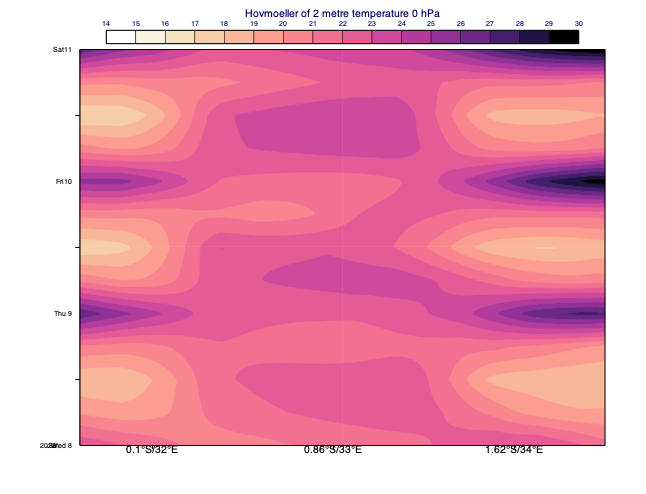

In [68]:
hov_view = mv.mhovmoellerview(
    type="line_hovm",
    line=line_across_lake_victoria,
    resolution=0.25,
    swap_axis="no"
)

# extract the 2m temperature on all the levels and timesteps. Values 
# scaled to Celsius units for plotting
t = data.select(shortName="2t")
t = t -273.16

# define contour shading for t2m
t_cont = mv.mcont(
    legend="on",
    contour="off",
    contour_level_selection_type="interval",
    contour_max_level=30,
    contour_min_level=14,
    contour_interval=1,
    contour_label="off",
    contour_shade="on",
    contour_shade_colour_method="palette",
    contour_shade_method="area_fill",
    contour_shade_palette_name="m_orange_purple_16",
)

# generate the line Hovmoeller plot. The computations are automatically 
# performed according to the settings in the view.
mv.plot(hov_view, t, t_cont)

## Gridpoint selection

In [69]:
# get value of single field at location
r1000 = data['r1000']
bologna_coords = [44.5, 11.3]

In [70]:
print(r1000.nearest_gridpoint(bologna_coords))

46.73977756500244


In [71]:
# get more info about the point
print(r1000.nearest_gridpoint_info(bologna_coords))

[{'latitude': 44.6489, 'longitude': 11.6471, 'index': 14251.0, 'distance': 32.0703, 'value': 46.7398}]


In [72]:
# get value of multiple fields at a single location
r = data['r']
print(r.nearest_gridpoint(bologna_coords))

[46.73977756500244, 63.34179496765137, 62.7387580871582, 54.288533210754395, 32.877156257629395, 34.60153579711914, 82.47459983825684, 101.11736679077148, 42.8692102432251, 3.479970932006836, 2.4789832830429077]


In [73]:
# get value of single field at multiple locations
lats = np.array([10, 20, 30, 40])
lons = np.array([45, 40, 35, 30])
print(r1000.nearest_gridpoint(lats, lons))

[21.67727757 76.52102757 18.95852757 56.11477757]


In [74]:
# get value of multiple fields at multiple locations (returns 2d numpy array)
lats = np.array([10, 20, 30, 40])
lons = np.array([45, 40, 35, 30])
print(r.nearest_gridpoint(lats, lons))

[[21.67727757 76.52102757 18.95852757 56.11477757]
 [24.24804497 20.84179497 20.74804497 60.49804497]
 [29.02000809 11.14500809 30.20750809 80.39500809]
 [63.72603321 13.63228321 13.25728321 75.38228321]
 [58.50215626  3.00215626 35.37715626 23.87715626]
 [12.1640358   8.1640358  40.5390358  33.4765358 ]
 [12.41209984  8.72459984 18.16209984 35.53709984]
 [21.36736679 22.24236679 10.11736679 25.05486679]
 [36.86921024 62.77546024 11.24421024  3.33796024]
 [91.01122093 54.79247093 18.57372093  2.72997093]
 [65.22898328 46.91648328 39.57273328  3.94773328]]


In [75]:
# interpolate the value at the point (because it does not fall exactly on a grid point)
print(r.interpolate(bologna_coords))

[45.3462287863336, 57.24063741008365, 62.874751901836966, 59.515108579518085, 38.87074203846925, 50.79850151897796, 95.72173420260529, 99.40602160846703, 42.18095344810713, 3.4901434575907517, 2.3958725332532467]


## Time series

In [76]:
# define the lat/lon coordinates of three locations
bologna_coords = [44.5, 11.3]
bonn_coords    = [50.7, 7.1]
reading_coords = [51.4, 0.98]

In [77]:
# extract point data from these locations from the 2m temperature data
t2m = data['2t'] - 273.16

bologna_vals = t2m.nearest_gridpoint(bologna_coords)
bonn_vals = t2m.nearest_gridpoint(bonn_coords)
reading_vals = t2m.nearest_gridpoint(reading_coords)
print(reading_vals)

# extract the valid times for the data
times = mv.valid_date(t2m)
times

[18.27154541015625, 17.10321044921875, 13.79827880859375, 13.430252075195312, 18.741119384765625, 16.882583618164062, 15.208755493164062, 15.868255615234375, 20.207778930664062, 18.510986328125, 13.99456787109375, 14.033859252929688, 19.8885498046875]


[datetime.datetime(2022, 6, 8, 12, 0),
 datetime.datetime(2022, 6, 8, 18, 0),
 datetime.datetime(2022, 6, 9, 0, 0),
 datetime.datetime(2022, 6, 9, 6, 0),
 datetime.datetime(2022, 6, 9, 12, 0),
 datetime.datetime(2022, 6, 9, 18, 0),
 datetime.datetime(2022, 6, 10, 0, 0),
 datetime.datetime(2022, 6, 10, 6, 0),
 datetime.datetime(2022, 6, 10, 12, 0),
 datetime.datetime(2022, 6, 10, 18, 0),
 datetime.datetime(2022, 6, 11, 0, 0),
 datetime.datetime(2022, 6, 11, 6, 0),
 datetime.datetime(2022, 6, 11, 12, 0)]

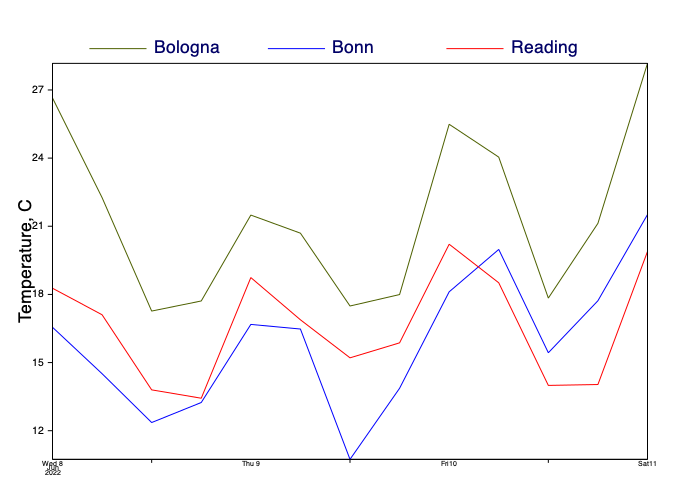

In [78]:
vaxis = mv.maxis(axis_title_text="Temperature, C", axis_title_height=0.5)

ts_view = mv.cartesianview(
    x_automatic="on",
    x_axis_type="date",
    y_automatic="on",
    vertical_axis=vaxis,
)

# create the curves for all locations
curve_bologna = mv.input_visualiser(
    input_x_type="date", input_date_x_values=times, input_y_values=bologna_vals
)

curve_bonn = mv.input_visualiser(
    input_x_type="date", input_date_x_values=times, input_y_values=bonn_vals
)

curve_reading = mv.input_visualiser(
    input_x_type="date", input_date_x_values=times, input_y_values=reading_vals
)

# set up visual styling for each curve
common_graph = {"graph_line_thickness": 2, "legend": "on"}
graph_bologna = mv.mgraph(common_graph, graph_line_colour="olive", legend_user_text="Bologna")
graph_bonn = mv.mgraph(common_graph, graph_line_colour="blue", legend_user_text="Bonn")
graph_reading = mv.mgraph(common_graph, graph_line_colour="red", legend_user_text="Reading")

# customise the legend
legend = mv.mlegend(legend_display_type="disjoint", legend_text_font_size=0.5)

# plot everything into the Cartesian view
mv.plot(ts_view, curve_bologna, graph_bologna, curve_bonn, graph_bonn, curve_reading, graph_reading, legend)